In [292]:
import numpy as np
import pandas as pd
import random as ran
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [378]:
class User:
    def __init__(self, user_id,improved_features, not_sincerity=False):
        self.user_id = user_id
        self.improved_features = improved_features
        self.survey = pd.DataFrame(columns=['no','temp','hum', 'lux', 'score'])
        self.not_sincerity = not_sincerity
        
    def save_survey(self, no,temp, hum, lux ,score):
        self.survey = self.survey.append({
            "no": no,
            "temp": temp,
            "hum": hum,
            "lux": lux,
            "score": score
        }, ignore_index=True)
    
    def score(self, temp, hum, lux):
        _score = np.array([0,0,0])
        
        if len(self.improved_features) == 0:
            if self.not_sincerity:
                for idx in range(0, len(_score)):
                    _score[idx] = 20
            else:
                one_line = ran.randrange(0, 2)
                if one_line == 0:
                    s = ran.randrange(5, 21, 5)
                    for idx in range(0, len(_score)):
                        _score[idx] = s
                else:
                    for idx in range(0, len(_score)):
                        _score[idx] = ran.randrange(5, 21)
        else:
            if 'temp' in self.improved_features:
                if (temp >= 18) & (temp <= 20):
                    _score[0] = 20
                else:
                    err = 0
                    if temp <= 18:
                        err = 18 - temp
                    else:
                        err = temp - 20
                    _score[0] = 20 - round(err / 2)
            else:
                _score[0] = ran.randrange(17, 21)
                    

            if 'hum' in self.improved_features:
                if (hum >= 40) & (hum <= 60):
                    _score[1] = 20
                else:
                    err = 0
                    if hum <= 40:
                        err = 40 - hum
                    else:
                        err = hum - 60
                    _score[1] = 20 - round(err / 5)
            else:
                _score[1] = ran.randrange(17, 21)


            if 'lux' in self.improved_features:
                if (lux >= 700) & (lux <= 1500):
                    _score[2] = 20
                else:
                    err = 0
                    if temp < 700:
                        err = 700 - lux
                    else:
                        err = lux - 1500
                    _score[2] = 20 - round(err / 100)
            else:
                _score[2] = ran.randrange(17, 21)

        return _score.sum()
    
def generate_features():
    features = ['temp', 'hum', 'lux']
    imp_features = list()
    for f in features:
        is_in = ran.randrange(0,2)
        if is_in == 0:
            imp_features.append(f)
    
    if len(imp_features) == 0:
        is_in = ran.randrange(0, 3)
        imp_features.append(features[is_in])
        
    return imp_features            

In [379]:
# 성실 참여자 50명 생성
users = list()
for user_id in range(0, 50):
    user = User(user_id, generate_features())
    users.append(user)
    
# 불성실 참여자 30명 생성
for user_id in range(50, 80):
    user = User(user_id, [])
    users.append(user)
    
# 매우불성실 참여자 20명 생성
for user_id in range(80, 100):
    user = User(user_id, [], True)
    users.append(user)
    
now = dt.datetime.now()

for days in range(1, 540):
    now_after = now + dt.timedelta(days=days)
    str_after = dt.datetime.strftime(now_after, '%Y-%m-%d')
    
    # 온도 10~32
    ran_temp = ran.randrange(10, 33)
    
    # 습도 30 ~ 80
    ran_hum = ran.randrange(30, 81)
    
    # 조도 200 ~ 1900 (100 단위)
    ran_lux = ran.randrange(200, 1901, 100)
    
    for user in users:
        _s = user.score(ran_temp,
                       ran_hum,
                       ran_lux)
        user.save_survey(
            days,
            ran_temp,
            ran_hum,
            ran_lux,
            _s
        )

In [354]:
user = users[0]
print("user id : {} / 중요 특징 : {}"
      .format(user.user_id, user.improved_features))

df = user.survey
df.head()

user id : 0 / 중요 특징 : ['lux']


,no,temp,hum,lux,score
0,1,28,77,1400,57
1,2,29,54,900,57
2,3,23,78,300,54
3,4,16,49,1300,57
4,5,12,51,1200,56


In [355]:
features = np.array(['no', 'temp', 'hum', 'lux'])

X = df[features].to_numpy().copy()
y = df[['score']].to_numpy().copy()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [356]:
RFModel = RandomForestRegressor(n_estimators=20,
                                oob_score=False,
                                random_state=531)

In [357]:
RFModel.fit(X_train, y_train.ravel())

RandomForestRegressor(n_estimators=20, random_state=531)

In [358]:
prediction = RFModel.predict(X_test)
mse = mean_squared_error(y_test,prediction)
print("MSE: {}".format(mse))

MSE: 3.08650462962963


In [359]:
feature_importance = RFModel.feature_importances_

In [360]:
print(feature_importance)

[0.02956252 0.01951354 0.02235862 0.92856531]


In [361]:
feature_importance = feature_importance / feature_importance.max()
print(feature_importance)

[0.03183677 0.02101472 0.02407868 1.        ]


In [362]:
sorted_idx = np.argsort(feature_importance)
print(sorted_idx[::-1])

[3 0 2 1]


In [363]:
bar_pos = np.arange(sorted_idx.shape[0]) + .5
bar_pos

array([0.5, 1.5, 2.5, 3.5])

In [364]:
feature_importance[sorted_idx]

array([0.02101472, 0.02407868, 0.03183677, 1.        ])

In [365]:
features[sorted_idx[::-1]]

array(['lux', 'no', 'hum', 'temp'], dtype='<U4')

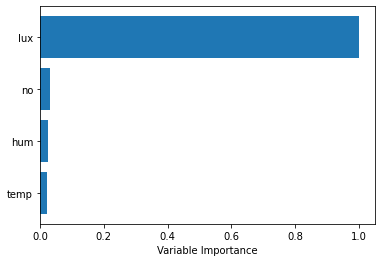

In [366]:
plt.barh(bar_pos, feature_importance[sorted_idx], align='center')
plt.yticks(bar_pos, features[sorted_idx])
plt.xlabel("Variable Importance")
plt.show()

# 실제 특징과 주요 특징 비교

In [380]:
features = np.array(['no', 'temp', 'hum', 'lux'])
_record = pd.DataFrame(columns=['user id',
                                'imp features', 
                                'RF imp features', 
                                'mse'])

for user in users:
    df = user.survey
    X = df[features].to_numpy().copy()
    y = df[['score']].to_numpy().copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

    RFModel = RandomForestRegressor(n_estimators=20,
                                oob_score=False,random_state=531)
    RFModel.fit(X_train, y_train.ravel())
    prediction = RFModel.predict(X_test)
    
    mse = mean_squared_error(y_test,prediction)
    
    feature_importance = RFModel.feature_importances_
    feature_importance = feature_importance / feature_importance.max()
    
    sorted_idx = np.argsort(feature_importance)
    bar_pos = np.arange(sorted_idx.shape[0]) + .5
    
    _features = features[sorted_idx[::-1]]
    
    user_id = user.user_id
    imp_features = user.improved_features
    imp_length = len(imp_features)
    if imp_length == 0:
        RF_imp_features = [_features[0]]
    else:
        RF_imp_features = _features[:imp_length]

    _record = _record.append({
        "user id": user_id,
        "mse": mse,
        "imp features": ",".join(imp_features),
        "RF imp features": ",".join(RF_imp_features)
    }, ignore_index=True)

/var/folders/52/4yvp7r991px0gmq4wyr894j40000gn/T/ipykernel_37390/3174755716.py:22: RuntimeWarning: invalid value encountered in true_divide
  feature_importance = feature_importance / feature_importance.max()
/var/folders/52/4yvp7r991px0gmq4wyr894j40000gn/T/ipykernel_37390/3174755716.py:22: RuntimeWarning: invalid value encountered in true_divide
  feature_importance = feature_importance / feature_importance.max()
/var/folders/52/4yvp7r991px0gmq4wyr894j40000gn/T/ipykernel_37390/3174755716.py:22: RuntimeWarning: invalid value encountered in true_divide
  feature_importance = feature_importance / feature_importance.max()
/var/folders/52/4yvp7r991px0gmq4wyr894j40000gn/T/ipykernel_37390/3174755716.py:22: RuntimeWarning: invalid value encountered in true_divide
  feature_importance = feature_importance / feature_importance.max()
/var/folders/52/4yvp7r991px0gmq4wyr894j40000gn/T/ipykernel_37390/3174755716.py:22: RuntimeWarning: invalid value encountered in true_divide
  feature_importance = f

In [381]:
_record

,user id,imp features,RF imp features,mse
0,0,"temp,lux","lux,temp",1.716644
1,1,"temp,hum,lux","lux,temp,hum",0.738750
2,2,"temp,hum,lux","lux,temp,hum",0.464352
3,3,"hum,lux","lux,hum",1.891736
4,4,lux,lux,3.503681
...,...,...,...,...
95,95,,lux,0.000000
96,96,,lux,0.000000
97,97,,lux,0.000000
98,98,,lux,0.000000
